In [46]:
# set run environment (local/colab)
# if colab install required packages and set appropriate root_path
import os

if os.getenv("COLAB_RELEASE_TAG"):
    colab = True
    from google.colab import drive
    drive.mount('/content/drive')
    root_path = '/content/drive/Othercomputers/My computer/EQILLM/'
    !pip install -r '/content/drive/Othercomputers/My computer/EQILLM/requirements.txt'
    !pip install transformers[torch]
    !pip install accelerate -U
    !pip install datasets
    !pip install torchinfo
    import sys
    sys.path.append(root_path)
    #ImportError: Using the `Trainer` with `PyTorch` requires `accelerate>=0.20.1`: Please run `pip install transformers[torch]` or `pip install accelerate -U
else:
    colab = False
    root_path = ''


import itertools
import pandas as pd
import openai
import datetime
import os
import csv
import glob
import matplotlib.pyplot as plt
import seaborn as sn

from dotenv import load_dotenv, dotenv_values
from tqdm.notebook import tqdm_notebook
from eqillm import finetune, get_log_for_val, validate, val_metrics, yeelight_eow_notification, param_combinations, load_PolarIs, df_to_ds
from sklearn.metrics import accuracy_score, f1_score, confusion_matrix
 


dotenv_config = dotenv_values(os.path.join(root_path, '.env'))
yeelight_notify = dotenv_config['YEELIGHT_NOTIFY'] if 'YEELIGHT_NOTIFY' in dotenv_config else False

In [47]:
def val_metrics(predicted, val_labels, filename):
    acc_sc = round(accuracy_score(val_labels, predicted), 3)
    f1_sc = round(f1_score(val_labels, predicted, average='macro'), 3)
    print(acc_sc, f1_sc)

    cm = confusion_matrix(val_labels, predicted, normalize='true')
    plot_cm(cm, val_labels, filename)

    return acc_sc, f1_sc

def plot_cm(cm, val_labels, filename):
    plt.figure()
    classes = list(set(val_labels))
    df_cm = pd.DataFrame(cm, index=classes, columns=classes)
    ax = sn.heatmap(df_cm, annot=True, fmt='.2g')
    ax.set_xlabel("Predicted")
    ax.set_ylabel("Target")
    ax.set_title(filename)

def find_labels_in_text(text, binary=False):
    temp = []
    if type(text)==str:
        text = text.lower()
        if not binary:
            if 'positive pathos' in text:
                temp.append('Positive')
            if 'negative pathos' in text:
                temp.append('Negative')
            if 'no pathos' in text:
                temp.append('No_pathos')
            if 'unclear' in text:
                temp.append('Unclear')
        else:
            if 'no pathos' in text:
                temp.append('No_pathos')
            elif 'pathos' in text:
                temp.append('Pathos')
        if len(temp)==1:
            return temp[0]
        else:
            return 'Unclear'
    else:
        return 'Unclear'


def validate_prompt_responses(path, filename):
    df = pd.read_csv(path, sep='|', header=0)
    if len(df.label.unique())==2:
        binary = True
    else:
        binary = False

    df['label_found'] = df['response'].apply(lambda x: find_labels_in_text(x, True))
    print(f"Dropped due to unclear label: {df[df['label_found']=='Unclear'].count()['label']}/{df.shape[0]}")
    df = df[df['label_found']!='Unclear']

    acc_sc, f1_sc = val_metrics(df['label_found'], df['label'], filename)

    return acc_sc, f1_sc

Dropped due to unclear label: 204/990
0.575 0.573


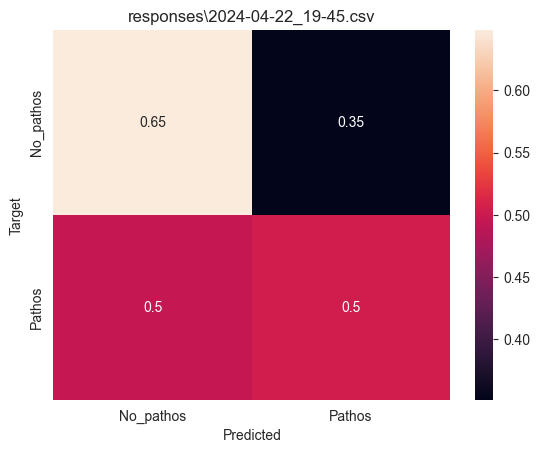

In [48]:
paths = glob.glob(os.path.join(root_path, 'output/prompting/responses/*'))[-1:]
# paths = [os.path.join(root_path, 'output/prompting/responses/2024-04-22_12-22.csv')]
scores = []
for path in paths:
    filename = path.rsplit('/')[-1]
    acc_sc, f1_sc = validate_prompt_responses(path, filename)
    scores.append([filename, acc_sc, f1_sc])